In [2]:
import polars as pl
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# UC Housing Data

In [3]:
df_2bdr = pl.read_csv('../data/2bdr.csv')
df_2bdr

Year,Oakland-Fremont,San Francisco,Santa Cruz,Merced,Los Angeles,Davis,Irvine,Riverside,San Diego,Santa Barbara
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
2019,2126,3170,2439,839,1791,1342,2037,1232,2460,1951
2020,2239,3339,2519,947,1956,1404,2216,1289,2570,2324
2021,2383,3553,3021,1067,2058,1511,2331,1390,2630,2374
2022,2274,3198,3138,1120,2044,1684,2324,1509,2710,2516
2023,2405,3188,3293,1243,2222,1851,2539,1751,2940,2667


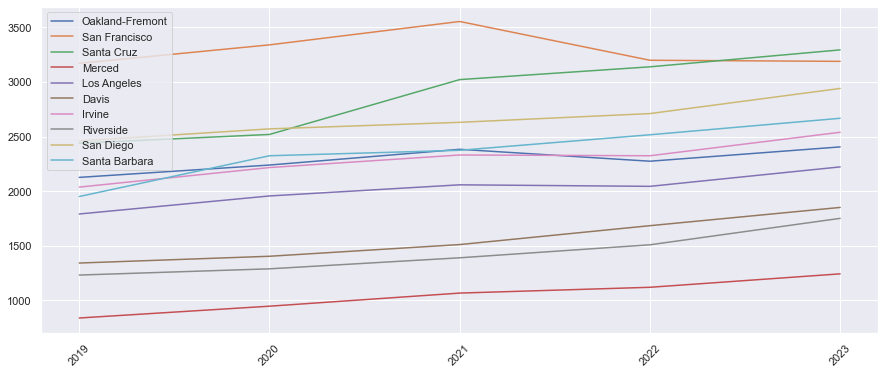

In [4]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 6)

for col in df_2bdr.select(pl.all().exclude('Year')).columns:
    plt.plot(df_2bdr['Year'], df_2bdr[col], label=f'{col}')

ax.legend()
plt.xticks(df_2bdr['Year'], rotation=45)
plt.show()


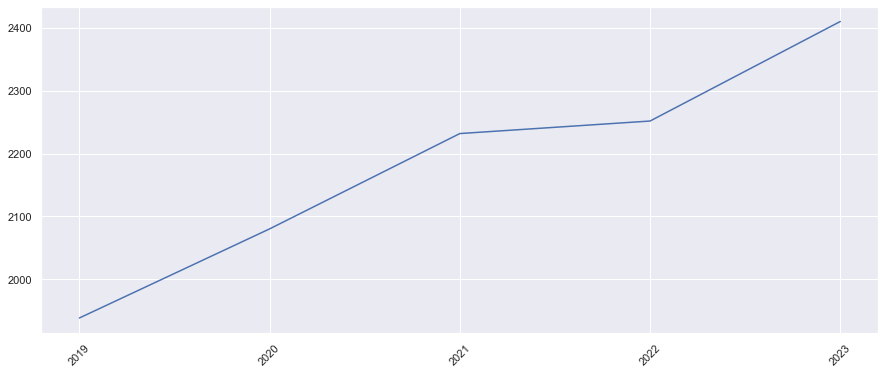

In [5]:
avg_yearly_change = df_2bdr.select([
    pl.col('Year'),
    pl.concat_list(pl.all().exclude('Year')).arr.eval(pl.element().mean()).arr.first().alias('AvgCost'),
])

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 6)
plt.plot(avg_yearly_change['Year'], avg_yearly_change['AvgCost'])
plt.xticks(avg_yearly_change['Year'], rotation=45)
plt.show()

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_18541/2698104104.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


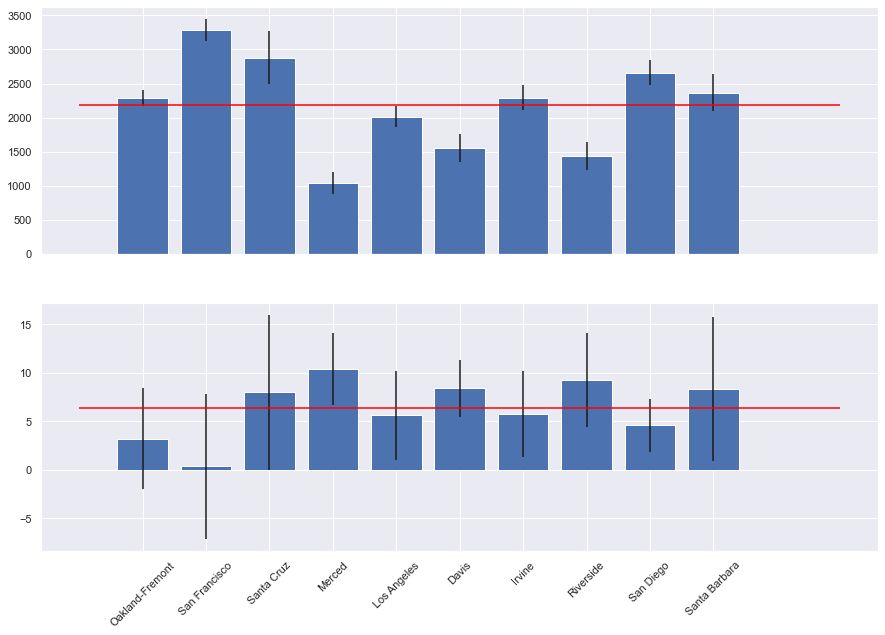

In [6]:
df_avg_cost_change = pl.concat([
    df_2bdr.select(pl.all().exclude('Year').mean().round(2)),
    df_2bdr.select(pl.all().exclude('Year').std().round(2)),
    df_2bdr.select((pl.all().exclude('Year').pct_change() * 100).mean().round(2)),
    df_2bdr.select((pl.all().exclude('Year').pct_change() * 100).std().round(2)),
], rechunk=True)


fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True) # frameon=False removes frames
fig.set_size_inches(15, 10)

ax1.bar(df_avg_cost_change.columns, df_avg_cost_change.row(0), yerr=df_avg_cost_change.row(1))
ax1.hlines(np.mean(df_avg_cost_change.row(0)), -1, 11, colors='red')

ax2.bar(df_avg_cost_change.columns, df_avg_cost_change.row(2), yerr=df_avg_cost_change.row(3))
ax2.hlines(np.mean(df_avg_cost_change.row(2)), -1, 11, colors='red')

plt.xticks(rotation=45)

fig.show()

In [7]:
np.corrcoef(df_avg_cost_change.row(0), df_avg_cost_change.row(2))

array([[ 1.        , -0.74757451],
       [-0.74757451,  1.        ]])

### Should we accept a 3%, 7%? What should the quantity be?

Probability of that year's increase in cost of living is greater than 7%

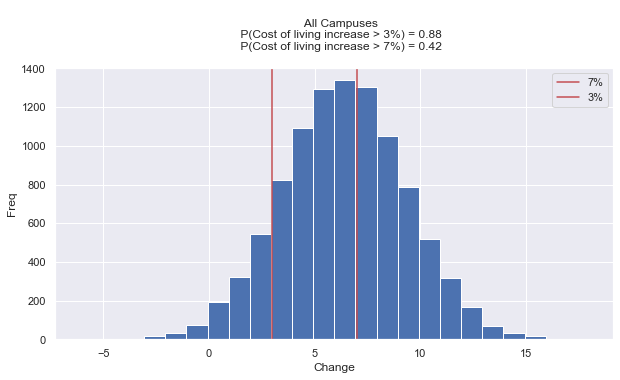

In [33]:
housing_cost = df_avg_cost_change.row(2)
avg_housing_cost = np.mean(housing_cost).round(2)
std_housing_cost = np.std(housing_cost).round(2)

sample = norm.rvs(
    loc=avg_housing_cost, 
    scale=std_housing_cost, 
    size=10_000, 
    random_state=42
)

fig, axs = plt.subplots(1)
fig.set_size_inches(10, 5)

axs.hist(sample, bins=np.arange(min(sample)-1, max(sample)+1, 1))
axs.axvline(x=7, color='r', label='7%')
axs.axvline(x=3, color='r', label='3%')

axs.set_xlabel('Change')
axs.set_ylabel('Freq')
axs.set_title(f'''
    All Campuses
    P(Cost of living increase > 3%) = {np.round(norm.sf(3, avg_housing_cost, std_housing_cost), 2)}
    P(Cost of living increase > 7%) = {np.round(norm.sf(7, avg_housing_cost, std_housing_cost), 2)}
''')

axs.legend()
plt.show()

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_18541/2955248883.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


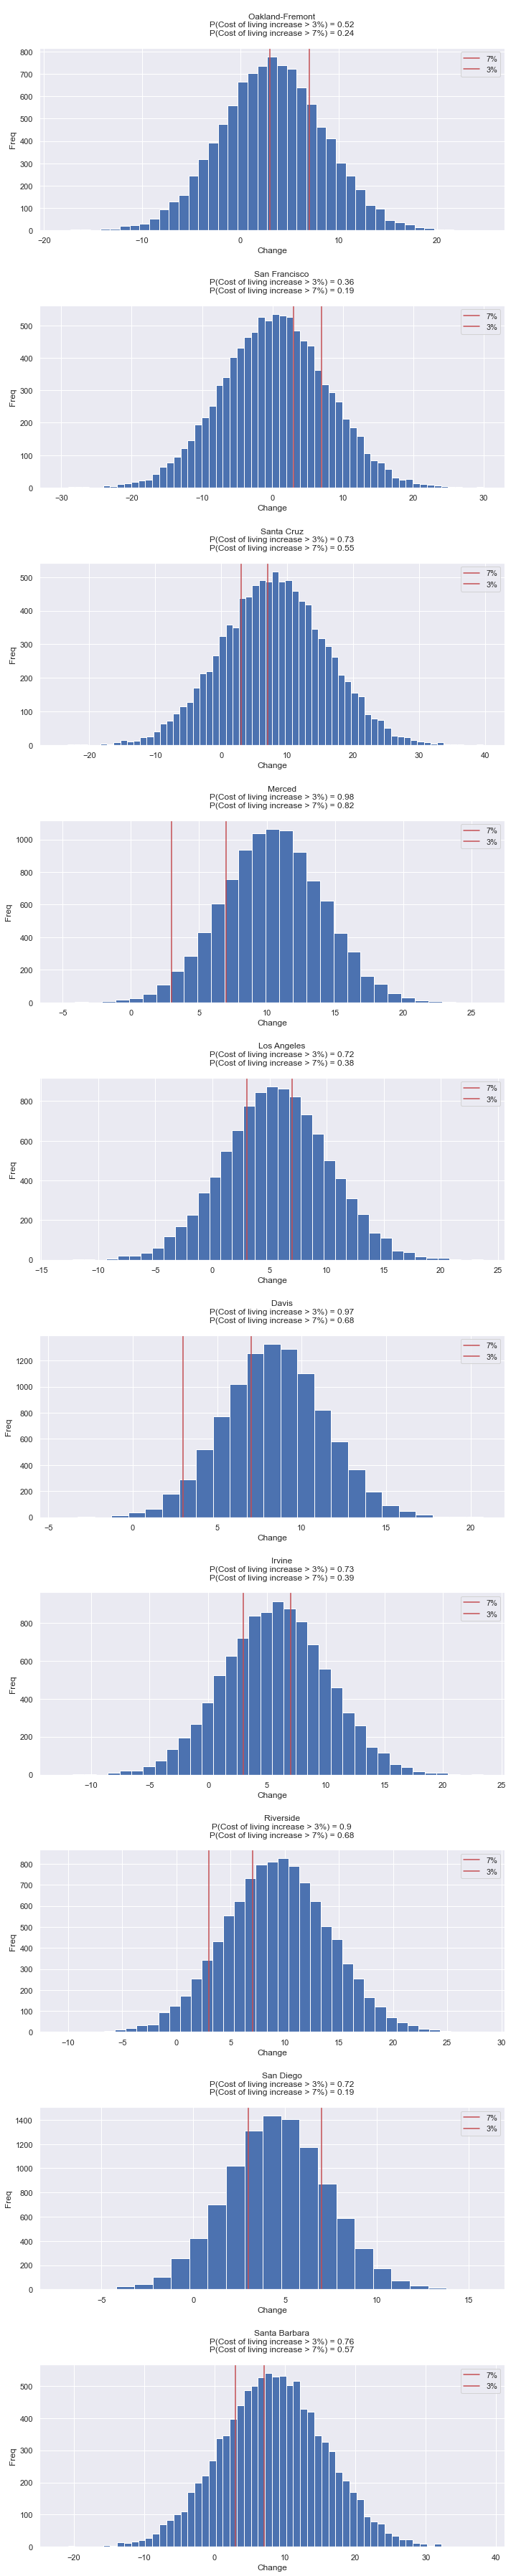

In [8]:

n = len(df_avg_cost_change.columns)

fig, axs = plt.subplots(n, 1, tight_layout=True)
fig.set_size_inches(10, n*5)
axs = axs.flatten()

for i, col in enumerate(df_avg_cost_change.columns):

    loc = df_avg_cost_change[col][2]
    scale = df_avg_cost_change[col][3]

    sample = norm.rvs(
        loc=loc, 
        scale=scale, 
        size=10_000, 
        random_state=42
    )

    axs[i].hist(sample, bins=np.arange(min(sample)-1, max(sample)+1, 1))
    axs[i].axvline(x=7, color='r', label='7%')
    axs[i].axvline(x=3, color='r', label='3%')

    axs[i].set_xlabel('Change')
    axs[i].set_ylabel('Freq')
    axs[i].set_title(f'''
        {col}
        P(Cost of living increase > 3%) = {np.round(norm.sf(3, loc, scale), 2)}
        P(Cost of living increase > 7%) = {np.round(norm.sf(7, loc, scale), 2)}
    ''')

    axs[i].legend()


fig.show()

# Standardized

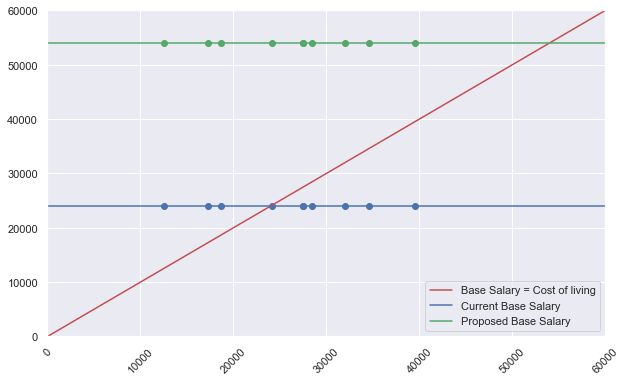

In [9]:
current_base_salary = 24_000
proposed_base_salary = 54_000

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

ax.axline([-1, -1], [1, 1], color='r', label='Base Salary = Cost of living')
ax.axhline(y=current_base_salary, color='b', label='Current Base Salary')
ax.axhline(y=proposed_base_salary, color='g', label='Proposed Base Salary')

compus_name = df_avg_cost_change.columns
x = np.array(df_avg_cost_change.row(0)) * 12
y = [current_base_salary] * len(x)
plt.scatter(x, y, marker='o', color='b')

compus_name = df_avg_cost_change.columns
x = np.array(df_avg_cost_change.row(0)) * 12
y = [proposed_base_salary] * len(x)
plt.scatter(x, y, marker='o', color='g')

ax.set(xlim=(0, 60_000), ylim=(0, 60_000))
ax.legend()
plt.xticks(rotation=45)
plt.show()

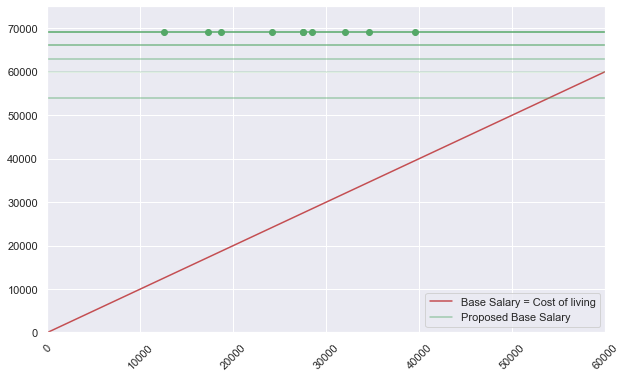

In [10]:
current_base_salary = 24_000
proposed_base_salary = 54_000

yearly_increase = 3000

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

ax.axline([-1, -1], [1, 1], color='r', label='Base Salary = Cost of living')
ax.axhline(y=proposed_base_salary, color='g', label='Proposed Base Salary', alpha=0.5)


n = 5
alphas = np.linspace(0, 1, n)
cum_yearly_increase = yearly_increase

for (i, alpha) in enumerate(alphas):
    proposed_base_salary += yearly_increase
    ax.axhline(y=proposed_base_salary, color='g', alpha=alphas[i])

compus_name = df_avg_cost_change.columns
x = np.array(df_avg_cost_change.row(0)) * 12
y = [proposed_base_salary] * len(x)
plt.scatter(x, y, marker='o', color='g')

ax.set(xlim=(0, 60_000), ylim=(0, 75_000))
ax.legend()
plt.xticks(rotation=45)
plt.show()

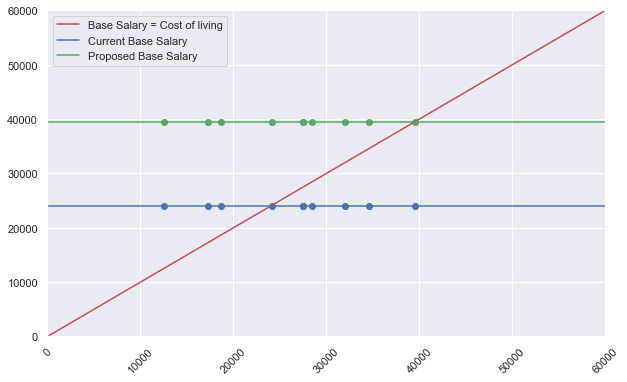

In [22]:
current_base_salary = 24_000
proposed_base_salary = 54_000

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

ax.axline([-1, -1], [1, 1], color='r', label='Base Salary = Cost of living')
ax.axhline(y=current_base_salary, color='b', label='Current Base Salary')


compus_name = df_avg_cost_change.columns
x = np.array(df_avg_cost_change.row(0)) * 12
y = [current_base_salary] * len(x)
plt.scatter(x, y, marker='o', color='b')

compus_name = df_avg_cost_change.columns
x = np.array(df_avg_cost_change.row(0)) * 12
y = [max(x)] * len(x)
plt.scatter(x, y, marker='o', color='g')
ax.axhline(y=max(x), color='g', label='Minimum Base Salary')

ax.set(xlim=(0, 60_000), ylim=(0, 60_000))
ax.legend()
plt.xticks(rotation=45)
plt.show()

# Localized

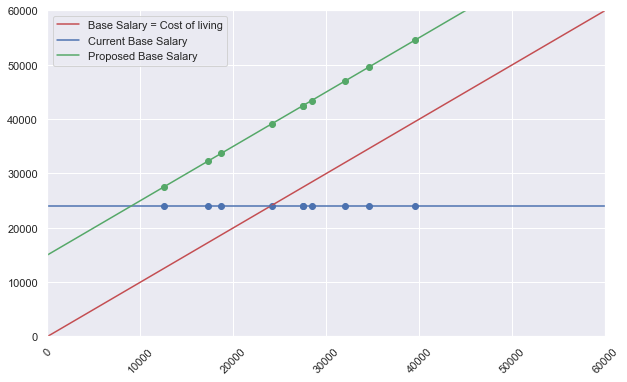

In [11]:
increase = 15_000

monthly_housing_cost = df_avg_cost_change.row(0)
yearly_housing_cost = np.array(monthly_housing_cost) * 12

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

ax.axline([0, 0], [1, 1], color='r', label='Base Salary = Cost of living')
ax.axhline(y=current_base_salary, color='b', label='Current Base Salary')
ax.axline([0, increase], [1, increase+1], color='g', label='Proposed Base Salary')

compus_name = df_avg_cost_change.columns
x = yearly_housing_cost
y = [current_base_salary] * len(x)
plt.scatter(x, y, marker='o', color='b')

compus_name = df_avg_cost_change.columns
x = np.array(df_avg_cost_change.row(0)) * 12
y = x + increase
plt.scatter(x, y, marker='o', color='g')

ax.set(xlim=(0, 60_000), ylim=(0, 60_000))
ax.legend()
plt.xticks(rotation=45)
plt.show()


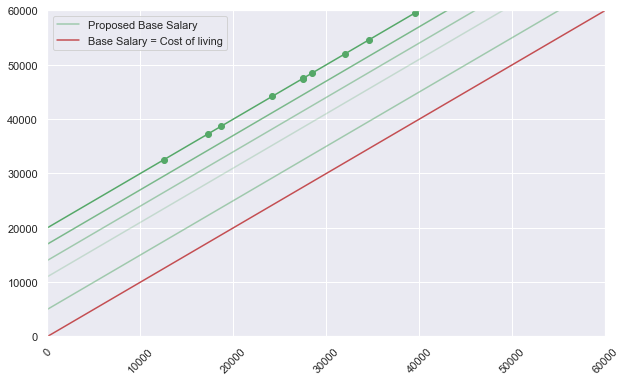

In [12]:
base_increase = 5000
yearly_increase = 3000

monthly_housing_cost = df_avg_cost_change.row(0)
yearly_housing_cost = np.array(monthly_housing_cost) * 12

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

minimum = 0.0001
alpha = 1

ax.axline([0, base_increase], [1, base_increase+1], color='g', label='Proposed Base Salary', alpha=0.5)



n = 5
alphas = np.linspace(0, 1, n)
cum_yearly_increase = yearly_increase

for (i, alpha) in enumerate(alphas):
    base_increase += yearly_increase
    ax.axline([0, base_increase], [1, base_increase+1], color='g', alpha=alphas[i])

ax.axline([0, 1], [1, 2], color='r', label='Base Salary = Cost of living', alpha=alphas[i])
    
compus_name = df_avg_cost_change.columns
x = np.array(df_avg_cost_change.row(0)) * 12
y = x + base_increase
plt.scatter(x, y, marker='o', color='g')


ax.set(xlim=(0, 60_000), ylim=(0, 60_000))
ax.legend()
plt.xticks(rotation=45)
plt.show()


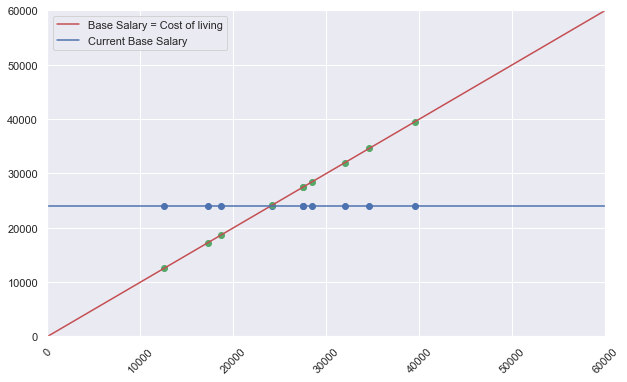

In [23]:
monthly_housing_cost = df_avg_cost_change.row(0)
yearly_housing_cost = np.array(monthly_housing_cost) * 12

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

ax.axline([0, 0], [1, 1], color='r', label='Base Salary = Cost of living')
ax.axhline(y=current_base_salary, color='b', label='Current Base Salary')

compus_name = df_avg_cost_change.columns
x = yearly_housing_cost
y = [current_base_salary] * len(x)
plt.scatter(x, y, marker='o', color='b')

compus_name = df_avg_cost_change.columns
x = np.array(df_avg_cost_change.row(0)) * 12
y = x
plt.scatter(x, y, marker='o', color='g')

ax.set(xlim=(0, 60_000), ylim=(0, 60_000))
ax.legend()
plt.xticks(rotation=45)
plt.show()
